In [ ]:
#imports required libraries
import numpy as np
from itertools import product, permutations
from functools import reduce
from scipy.stats import unitary_group
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.stats import unitary_group  # optional: compare to Haar later
from numpy import kron
import matplotlib.pyplot as plt
import qutip.piqs as pq

In [ ]:
# Matplotlib settings for the plots
plt.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": "cm",
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
    "font.size": 10,
    "axes.labelsize": 9,
    "axes.titlesize": 9,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "lines.linewidth": 1.4,
    "axes.linewidth": 0.8,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "savefig.dpi": 600,
    "savefig.bbox": "tight",
})

In [ ]:
# Functions that will be used in the simulations

# This function defines the collective Sz operator
def S_z_operator(n): 
    sz = np.array([[1, 0], [0, -1]], dtype=complex) / 2 # single qubit S_z operator
    I = np.eye(2, dtype=complex)
    op = 0
    # Constructs the collective S_z operator iteratively
    for i in range(n):
        term = 1
        for j in range(n):
            term = kron(term, sz if i == j else I)
        op += term
    return op

 # This function returns the projector that will be used in the protocol using projected ensembles
def projector_X1_plus(n): 
    X_plus = np.array([[0.5, 0.5], [0.5, 0.5]], dtype=complex)
    I = np.eye(2, dtype=complex)
    P = X_plus
    for _ in range(n - 1):
        P = kron(P, I)
    return P

# This function returns the fisher information given the state(psi) and generator(G)
def fisher_information(psi, G):
    mean = np.vdot(psi, G @ psi)
    mean_sq = np.vdot(psi, G @ (G @ psi))
    var = mean_sq - mean**2
    return 4 * np.real(var)

# This function samples multiple instances of random unitaries for various system sizes
# and returns an array containing the mean and standard deviation of QFI corresponding to each system size
def simulate_qfi(n_values, sample_sizes, projector_func):
    data = {}
    for num_runs in sample_sizes:
        avg_FI, std_FI = [], []
        for n in n_values:
            d = 2**n # dimension of the Hilbert space
            Sz = S_z_operator(n) # collective S_z operator
            P = projector_func(n) # projection operation for the protocol
            FI_list = []
            # Samples random unitaries and compute QFI
            for _ in range(num_runs): 
                psi0 = np.zeros(d, dtype=complex) 
                psi0[0] = 1.0               # initial state |0...0>
                U = unitary_group.rvs(d)    # Haar random unitary
                phi = P @ (U @ psi0).       # apply U and then project
                if np.linalg.norm(phi) < 1e-12:
                    continue
                psi = U.conj().T @ phi      # back-evolve the projected state
                psi /= np.linalg.norm(psi)  # normalize the state
                # compute QFI for the state (psi) for phase encoding with generator (Sz) and append to list (FI_list)
                FI_list.append(fisher_information(psi, Sz)) 
            avg_FI.append(np.mean(FI_list)) # average QFI over samples
            std_FI.append(np.std(FI_list)) # standard deviation of QFI over samples
        data[num_runs] = (np.array(avg_FI), np.array(std_FI))
    return data

# This function returns a dictionary for Pauli words
def pauli_basis_list():
    I = np.array([[1,0],[0,1]],complex)
    X = np.array([[0,1],[1,0]],complex)
    Y = np.array([[0,-1j],[1j,0]],complex)
    Z = np.array([[1,0],[0,-1]],complex)
    return {'I':I,'X':X,'Y':Y,'Z':Z}

# Define the Pauli matrices
I = np.array([[1,0],[0,1]],complex)
X = np.array([[0,1],[1,0]],complex)
Y = np.array([[0,-1j],[1j,0]],complex)
Z = np.array([[1,0],[0,-1]],complex)

# Retuns all possible Pauli words for a given number of qubits
def pauli_words(n):
    P = pauli_basis_list()
    labels = [''.join(p) for p in product('IXYZ', repeat=n)]
    mats = [reduce(np.kron, [P[s] for s in lab]) for lab in labels] 
    return mats, labels #returns list of matrices and their labels

# Function that returns the Pauli weight distribution (grouped by [n_x + n_y] and [n_i + n_z])
def pauli_weight_distribution(operator, n):
    ops, labels = pauli_words(n) # get all Pauli words for n qubits
    coeffs = np.array([np.trace(operator @ P) for P in ops]) # coefficients in Pauli basis
    probs = np.abs(coeffs)**2 # probabilities from coefficients before normalization
    probs = np.abs(coeffs)**2 / np.sum(probs) # normalize the probabilities
    # group by [n_x + n_y] and [n_i + n_z]
    iz_weight_bins = np.zeros(n+1)  # no of possible bins = n+1 (0-n)
    xy_weight_bins = np.zeros(n+1)  # no of possible bins = n+1 (0-n)
    total_weight_bins = np.zeros(n+1)  
    # collect the probabilities into bins (grouped by weights) that define equivalence classes
    for lab, p in zip(labels, probs):
        nx = lab.count("X") # count no. of X's
        ny = lab.count("Y")
        nz = lab.count("Z")
        ni = lab.count("I")
        w = int(nx + ny)     # xy weight
        wi = int(nz + ni)    # iz weight
        tw = int(nx + ny + nz + ni)
        xy_weight_bins[w] += p # accumulate probability in the corresponding bins
        iz_weight_bins[wi] += p # accumulate probability in the corresponding bins
        total_weight_bins[tw] += p
    # return the distributions as numpy arrays
    return np.array(xy_weight_bins), np.array(iz_weight_bins), np.array(total_weight_bins)

# This function returns the Kronecker product of a list of operators
def tensor_product(ops):
    result = ops[0] #initialize with the first operator
    # Compute the Kronecker product iteratively
    for op in ops[1:]:
        result = kron(result, op)
    return result

# This function returns the distribution of non-commuting operators given a state
def excitation_distribution(state, n): 
    probs = np.abs(state)**2 
    excitation_probs = np.zeros(n + 1) # an array to hold possible values (0-n)
    # Accumulate probabilities based on the number of excitations
    for i, p in enumerate(probs): 
        k = bin(i).count("1")
        excitation_probs[k] += p
    # Normalize to avoid small floating errors
    return excitation_probs / np.sum(excitation_probs)


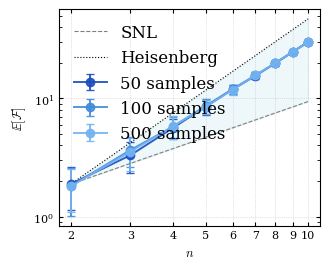

In [14]:
## This snippet of code creates the plot in the inset of Fig. 3 in the main text.

n_values1 = np.arange(2, 11)
sample_sizes = [50, 100, 500]
data_row1 = simulate_qfi(n_values1, sample_sizes, projector_X1_plus)

colors = [
    (0.1, 0.3, 0.75, 1.0),
    (0.25, 0.55, 0.85, 1.0),
    (0.45, 0.7, 0.95, 1.0)
]

def plot_combined(n_values, data_dict, title, ylabel=None):
    plt.figure(figsize=(3.4, 2.8))
    for idx, (num_runs, (avg_FI, std_FI)) in enumerate(data_dict.items()):
        color = colors[idx % len(colors)]
        plt.errorbar(
            n_values, avg_FI, yerr=std_FI, fmt='o-', color=color, capsize=3,
            label=f"{num_runs} samples", alpha=0.9
        )

    # SNL & Heisenberg scaling 
    snl = n_values / n_values[0] * list(data_dict.values())[0][0][0]
    heis = (n_values**2) / (n_values[0]**2) * list(data_dict.values())[0][0][0]
    plt.loglog(n_values, snl, '--', color='gray', lw=0.8, label='SNL')
    plt.loglog(n_values, heis, ':', color='black', lw=0.8, label='Heisenberg')
    plt.fill_between(n_values, snl, heis, color='lightblue', alpha=0.2)
    plt.xscale("log")
    plt.yscale("log")

    if ylabel:
        plt.ylabel(ylabel)
    plt.xlabel(r"$n$")
    plt.xticks(n_values, [str(int(n)) for n in n_values])

    plt.grid(True, ls=':', lw=0.5, alpha=0.7)
    plt.legend(frameon=False, fontsize=12, loc='upper left')
    plt.tight_layout()
    plt.savefig(title)
    plt.show()  

# Plots the results 
plot_combined(n_values1, data_row1, r"$\pi_{X_1}^+$.svg", ylabel=r"${\mathbb{E}}[\mathcal{F}]$")

/var/folders/gl/34c8dgjj78b7rd09ysltwhhw0000gn/T/ipykernel_35482/3221674009.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


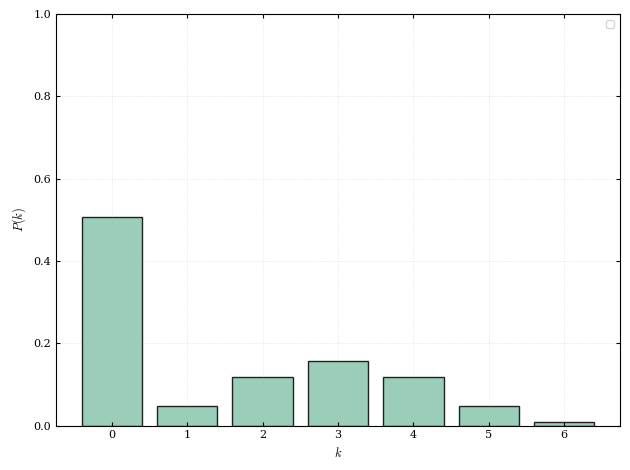

In [ ]:
## This snippet of code creates the main plot in Fig. 3 of the main text.

n = 6 # number of qubits
d = 2**n  # dimension of Hilbert space
num_runs = 500  # number of random unitaries to sample
P_plus = projector_X1_plus(n)
xy_weight_avg_p = np.zeros(n+1)
total_weight_avg_p = np.zeros(n+1)
iz_weight_avg_p = np.zeros(n+1)
## To study excitation distribution as well 
## (Note that the excitation distribution here gives the same result as the equivalence class distribution of the probe preparation operator.)
# state0 = np.zeros(d, dtype=complex)
# state0[0] = 1.0  # initial state |0...0>
# probs_accum = np.zeros(n+1)
# count = 0
for _ in range(num_runs):
    # Haar random unitary   
    U = unitary_group.rvs(d)
    # Apply U, then projection
    operator = P_plus @ (U)
    if np.linalg.norm(operator) < 1e-12:
        continue
    # Now, apply U^\dagger to complete the procedure
    op = U.conj().T @ operator
    op = op / np.linalg.norm(op)
    xy_weight_p, iz_weight_p, total_weight_p = pauli_weight_distribution(op, n)
    xy_weight_avg_p += xy_weight_p
    iz_weight_avg_p += iz_weight_p
    total_weight_avg_p += total_weight_p

    ## To study excitation distribution as well
    # state0 = np.zeros(d, dtype=complex)
    # state0[0] = 1.0  # initial state |0...0>
    # psi_proj = U.conj().T @ (P_plus @ (U @ state0))
    # norm = np.linalg.norm(psi_proj)
    # psi_proj = psi_proj / norm
    # probs_accum += excitation_distribution(psi_proj, n)

xrange = range(n + 1)
probs = xy_weight_avg_p / num_runs
plt.grid(True, ls=':', lw=0.4, alpha=0.6)
plt.bar(xrange, probs, width=0.8, align='center', color="#8ac6adff", edgecolor='black', alpha=0.85)
plt.ylim(0, 1.0)
plt.xlabel('$k$')
plt.ylabel('$P(k)$')
plt.legend()
plt.tight_layout()
plt.show()
## To study excitation distribution as well
# excit_probs = probs_accum/num_runs
# plt.plot(xrange, excit_probs, 'o-', label='Excitation Number Distribution')
# plt.xlabel('$k$')
# plt.ylabel('$P(k)$')
# plt.legend()
# plt.show()